In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import pandas as pd

DataPath = './weather.csv'
Dataframe = pd.read_csv(DataPath).reset_index(drop=True)

Dataframe.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   province  181960 non-null  object 
 1   max       181960 non-null  int64  
 2   min       181960 non-null  int64  
 3   wind      181960 non-null  int64  
 4   wind_d    181960 non-null  object 
 5   rain      181960 non-null  float64
 6   humidi    181960 non-null  int64  
 7   cloud     181960 non-null  int64  
 8   pressure  181960 non-null  int64  
 9   date      181960 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 13.9+ MB


In [3]:
Dataframe['temp'] = (Dataframe['max'] + Dataframe['min']) / 2
NewDf = Dataframe[['temp', 'wind', 'humidi', 'cloud', 'pressure']]

RainThreshold = 0.5
NewDf['israin'] = (Dataframe['rain'] > RainThreshold).astype(int)

NewDf['wind'] *= 0.277777778 # km/h to m/s

NewDf.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      181960 non-null  float64
 1   wind      181960 non-null  float64
 2   humidi    181960 non-null  int64  
 3   cloud     181960 non-null  int64  
 4   pressure  181960 non-null  int64  
 5   israin    181960 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 8.3 MB


In [4]:
NewDf.head(10)

,temp,wind,humidi,cloud,pressure,israin
0,24.5,4.722222,90,71,1010,1
1,28.0,5.555556,64,24,1010,0
2,26.5,3.888889,75,45,1008,0
3,27.0,8.333333,79,52,1012,0
4,28.0,5.555556,70,24,1010,0
5,25.5,3.888889,75,55,1012,0
6,26.0,2.777778,75,42,1012,0
7,28.0,6.111111,63,9,1015,0
8,27.0,5.555556,76,35,1011,0
9,26.0,4.444444,70,33,1010,0


In [5]:
import numpy as np

Data = NewDf.drop(columns='israin').values
Target = NewDf['israin'].values

np.save('./Data.npy', Data)
np.save('./Target.npy', Target)

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('Standard scaling', StandardScaler()),
     ('Normalize', Normalizer())]).fit(X=Data, y=Target)

Data = pipeline.transform(X=Data)
Target = LabelEncoder().fit_transform(Target)

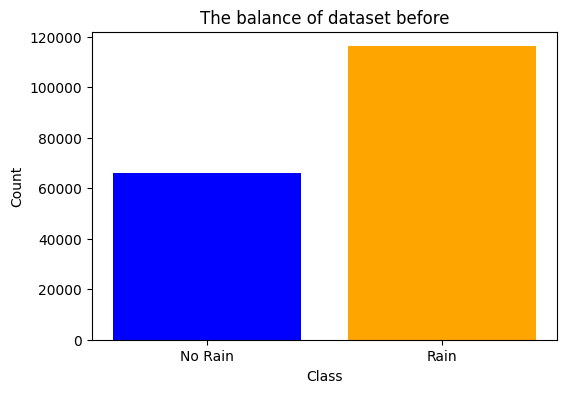

In [7]:
import matplotlib.pyplot as plt
import numpy as np

unique_values, counts = np.unique(Target, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique_values, counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('The balance of dataset before')
plt.xticks(unique_values, ['No Rain', 'Rain'])
plt.show()

In [8]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, label):
      super().__init__()
      self.train = data
      self.label = label

    def __len__(self):
      return self.train.shape[0]

    def __getitem__(self, index: int):
        return self.train[index], self.label[index]

X_train, X_test, Y_train, Y_test = train_test_split(Data, Target, test_size=0.2)

# Convert data to PyTorch tensors and move to GPU
TrainData = torch.tensor(X_train, dtype=torch.float32, device=device)
TrainLabel = torch.tensor(Y_train, dtype=torch.long, device=device)

ValidData = torch.tensor(X_test, dtype=torch.float32, device=device)
ValidLabel = torch.tensor(Y_test, dtype=torch.long, device=device)

# Create dataloader
TrainDataset = CustomDataset(TrainData, TrainLabel)
ValidDataset = CustomDataset(ValidData, ValidLabel)

TrainDataloader = DataLoader(TrainDataset, batch_size=64, shuffle=True, num_workers=4)
ValidDataloader = DataLoader(ValidDataset, batch_size=64, shuffle=True, num_workers=4)

In [10]:
import torch

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.report = None
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False

    def __call__(self, model, val_loss, val_acc, report):


        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.report = report
            ExportPATH = f'./ModelCheckpoint/SoftOrdering1DCNN.pth'
            torch.save(model.state_dict(), ExportPATH)

        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best loss: {self.best_loss}')
            print(f'Best accuracy: {self.best_acc}')

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.report = report
            self.counter = 0
            ExportPATH = f'./ModelCheckpoint/SoftOrdering1DCNN.pth'
            torch.save(model.state_dict(), ExportPATH)

In [11]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def TrainModel(model, loss_fn, optimizer, train_loader, scheduler=None, schd_batch_update=False):
        model.train()
        running_loss = None

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (data, label) in pbar:
            scaler = GradScaler()
            with autocast():
                output = model(data)
                loss = loss_fn(output, label)
                scaler.scale(loss).backward()

                if running_loss is None:
                    running_loss = loss.item()
                else:
                    running_loss = running_loss * .99 + loss.item() * .01

                if ((step + 1) %  2 == 0) or ((step + 1) == len(train_loader)):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                    if scheduler is not None and schd_batch_update:
                        scheduler.step()

                if ((step + 1) % 2 == 0) or ((step + 1) == len(train_loader)):
                    description = f'Loss: {running_loss:.4f}'

                    pbar.set_description(description)

        if scheduler is not None and not schd_batch_update:
           scheduler.step()

def EvalModel(model, loss_fn, val_loader, early_stopping=None, scheduler=None, schd_loss_update=False):
        model.eval()

        loss_sum = 0
        sample_num = 0
        preds_all = []
        targets_all = []

        pbar = tqdm(enumerate(val_loader), total=len(val_loader))
        for step, (data, label) in pbar:
            predict = model(data)
            preds_all += [torch.argmax(predict, 1).detach().cpu().numpy()]
            targets_all += [label.detach().cpu().numpy()]

            loss = loss_fn(predict, label)

            loss_sum += loss.item() * label.shape[0]
            sample_num += label.shape[0]

            if ((step + 1) % 2 == 0) or ((step + 1) == len(val_loader)):
                description = f'Loss: {loss_sum/sample_num:.4f}'
                pbar.set_description(description)

        preds_all = np.concatenate(preds_all)
        targets_all = np.concatenate(targets_all)

        report = classification_report(targets_all, preds_all, digits=4)
        print("Classification report")
        print(report)
        print("F1 micro averaging:",(f1_score(targets_all, preds_all, average='micro')))

        ValidLoss = loss_sum/sample_num
        ValidAcc = (preds_all==targets_all).mean()

        print('Validation loss', ValidLoss)
        print('Validation accuracy', ValidAcc)
        if early_stopping != None:
          early_stopping(model, ValidLoss, ValidAcc, report)

        if scheduler is not None:
            if schd_loss_update:
                scheduler.step(loss_sum/sample_num)
            else:
                scheduler.step()

In [12]:
from SoftOrdering1DCNN import SoftOrdering1DCNN
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch import nn
torch.backends.cudnn.benchmark = True

input_dim = TrainData.shape[1]
numclass = len(np.unique(TrainLabel.cpu()))
print(f'Feature: {input_dim}')
print(f'Classes: {numclass}')

print('Start building Model...')
model = SoftOrdering1DCNN(input_dim, numclass)
model.to(device)
print('Build Model successfully!')

from adabelief_pytorch import AdaBelief
optimizer = AdaBelief(model.parameters(),
                      lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decay=1e-4,
                      weight_decouple=False, rectify=False, fixed_decay=False, amsgrad=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-4, last_epoch=-1)
early_stopping = EarlyStopping(patience=10)

loss_tr = nn.CrossEntropyLoss().to(device)
loss_vl = nn.CrossEntropyLoss().to(device)

epoch = 0
while True:
    epoch += 1
    print('=================================================')
    print(f'\n[ TRAINING EPOCH {epoch} ]')
    TrainModel(model, loss_tr, optimizer, TrainDataloader, scheduler=scheduler, schd_batch_update=True)
    with torch.no_grad():
      print('\n[ EVALUATING VALIDATION ACCURACY ]')
      EvalModel(model, loss_vl, ValidDataloader, early_stopping)
      print('\n-------------------------------------------------\n')
      if early_stopping.early_stop:
            break

Feature: 5
Classes: 2
Start building Model...
Build Model successfully!
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.


[ TRAINING EPOCH 1 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5483: 100%|██████████| 2275/2275 [00:41<00:00, 55.38it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4783: 100%|██████████| 569/569 [00:04<00:00, 121.49it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8005    0.6997    0.7467     13249
           1     0.8396    0.9002    0.8689     23143

    accuracy                         0.8272     36392
   macro avg     0.8201    0.7999    0.8078     36392
weighted avg     0.8254    0.8272    0.8244     36392

F1 micro averaging: 0.8271872939107496
Validation loss 0.47827115206174414
Validation accuracy 0.8271872939107496

-------------------------------------------------


[ TRAINING EPOCH 2 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5496: 100%|██████████| 2275/2275 [00:40<00:00, 55.59it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4773: 100%|██████████| 569/569 [00:04<00:00, 124.11it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8018    0.7002    0.7476     13249
           1     0.8400    0.9009    0.8694     23143

    accuracy                         0.8278     36392
   macro avg     0.8209    0.8006    0.8085     36392
weighted avg     0.8261    0.8278    0.8250     36392

F1 micro averaging: 0.8278467795119806
Validation loss 0.477310809297178
Validation accuracy 0.8278467795119806

-------------------------------------------------


[ TRAINING EPOCH 3 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5416: 100%|██████████| 2275/2275 [00:40<00:00, 56.24it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4772: 100%|██████████| 569/569 [00:04<00:00, 122.30it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8057    0.6930    0.7451     13249
           1     0.8373    0.9043    0.8695     23143

    accuracy                         0.8274     36392
   macro avg     0.8215    0.7987    0.8073     36392
weighted avg     0.8258    0.8274    0.8242     36392

F1 micro averaging: 0.8273796438777754
Validation loss 0.4772375495217873
Validation accuracy 0.8273796438777753

-------------------------------------------------


[ TRAINING EPOCH 4 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5467: 100%|██████████| 2275/2275 [00:39<00:00, 57.27it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4779: 100%|██████████| 569/569 [00:04<00:00, 127.06it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8122    0.6794    0.7399     13249
           1     0.8322    0.9101    0.8694     23143

    accuracy                         0.8261     36392
   macro avg     0.8222    0.7948    0.8047     36392
weighted avg     0.8249    0.8261    0.8223     36392

F1 micro averaging: 0.8261156298087491
Validation loss 0.47787516460127294
Validation accuracy 0.8261156298087492
EarlyStopping counter: 1 out of 10
Best loss: 0.4772375495217873
Best accuracy: 0.8273796438777753

-------------------------------------------------


[ TRAINING EPOCH 5 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5422: 100%|██████████| 2275/2275 [00:39<00:00, 57.15it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4765: 100%|██████████| 569/569 [00:04<00:00, 123.01it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7969    0.7114    0.7517     13249
           1     0.8444    0.8962    0.8695     23143

    accuracy                         0.8289     36392
   macro avg     0.8206    0.8038    0.8106     36392
weighted avg     0.8271    0.8289    0.8266     36392

F1 micro averaging: 0.8289184436139811
Validation loss 0.4765098363482106
Validation accuracy 0.8289184436139811

-------------------------------------------------


[ TRAINING EPOCH 6 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5494: 100%|██████████| 2275/2275 [00:40<00:00, 56.64it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4767: 100%|██████████| 569/569 [00:04<00:00, 123.42it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8080    0.6921    0.7455     13249
           1     0.8371    0.9058    0.8701     23143

    accuracy                         0.8280     36392
   macro avg     0.8225    0.7989    0.8078     36392
weighted avg     0.8265    0.8280    0.8248     36392

F1 micro averaging: 0.8280116509122885
Validation loss 0.4767466567916958
Validation accuracy 0.8280116509122885
EarlyStopping counter: 1 out of 10
Best loss: 0.4765098363482106
Best accuracy: 0.8289184436139811

-------------------------------------------------


[ TRAINING EPOCH 7 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5420: 100%|██████████| 2275/2275 [00:40<00:00, 56.02it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4765: 100%|██████████| 569/569 [00:04<00:00, 121.75it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8096    0.6899    0.7450     13249
           1     0.8363    0.9071    0.8703     23143

    accuracy                         0.8280     36392
   macro avg     0.8230    0.7985    0.8076     36392
weighted avg     0.8266    0.8280    0.8247     36392

F1 micro averaging: 0.8280391294790064
Validation loss 0.476467345351307
Validation accuracy 0.8280391294790064

-------------------------------------------------


[ TRAINING EPOCH 8 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5431: 100%|██████████| 2275/2275 [00:43<00:00, 51.92it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4759: 100%|██████████| 569/569 [00:04<00:00, 121.30it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7949    0.7125    0.7515     13249
           1     0.8446    0.8948    0.8690     23143

    accuracy                         0.8284     36392
   macro avg     0.8198    0.8036    0.8102     36392
weighted avg     0.8265    0.8284    0.8262     36392

F1 micro averaging: 0.8284238294130578
Validation loss 0.4759343395811774
Validation accuracy 0.8284238294130578

-------------------------------------------------


[ TRAINING EPOCH 9 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5400: 100%|██████████| 2275/2275 [00:53<00:00, 42.69it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4774: 100%|██████████| 569/569 [00:07<00:00, 80.82it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8015    0.7038    0.7495     13249
           1     0.8415    0.9002    0.8699     23143

    accuracy                         0.8287     36392
   macro avg     0.8215    0.8020    0.8097     36392
weighted avg     0.8269    0.8287    0.8260     36392

F1 micro averaging: 0.8286986150802375
Validation loss 0.4773982436047934
Validation accuracy 0.8286986150802375
EarlyStopping counter: 1 out of 10
Best loss: 0.4759343395811774
Best accuracy: 0.8284238294130578

-------------------------------------------------


[ TRAINING EPOCH 10 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5453: 100%|██████████| 2275/2275 [00:54<00:00, 41.71it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4786: 100%|██████████| 569/569 [00:07<00:00, 80.84it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8344    0.6493    0.7303     13249
           1     0.8219    0.9262    0.8709     23143

    accuracy                         0.8254     36392
   macro avg     0.8282    0.7878    0.8006     36392
weighted avg     0.8264    0.8254    0.8198     36392

F1 micro averaging: 0.8254286656408002
Validation loss 0.47857447719018414
Validation accuracy 0.8254286656408002
EarlyStopping counter: 2 out of 10
Best loss: 0.4759343395811774
Best accuracy: 0.8284238294130578

-------------------------------------------------


[ TRAINING EPOCH 11 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5432: 100%|██████████| 2275/2275 [00:52<00:00, 43.61it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4759: 100%|██████████| 569/569 [00:07<00:00, 81.09it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8016    0.7044    0.7499     13249
           1     0.8417    0.9002    0.8700     23143

    accuracy                         0.8289     36392
   macro avg     0.8217    0.8023    0.8099     36392
weighted avg     0.8271    0.8289    0.8263     36392

F1 micro averaging: 0.8289184436139811
Validation loss 0.4759310546694915
Validation accuracy 0.8289184436139811

-------------------------------------------------


[ TRAINING EPOCH 12 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5409: 100%|██████████| 2275/2275 [00:52<00:00, 43.61it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4762: 100%|██████████| 569/569 [00:07<00:00, 79.85it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7929    0.7157    0.7523     13249
           1     0.8458    0.8930    0.8688     23143

    accuracy                         0.8284     36392
   macro avg     0.8193    0.8043    0.8105     36392
weighted avg     0.8265    0.8284    0.8264     36392

F1 micro averaging: 0.8284238294130578
Validation loss 0.47621818497092366
Validation accuracy 0.8284238294130578
EarlyStopping counter: 1 out of 10
Best loss: 0.4759310546694915
Best accuracy: 0.8289184436139811

-------------------------------------------------


[ TRAINING EPOCH 13 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5447: 100%|██████████| 2275/2275 [00:51<00:00, 44.34it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4764: 100%|██████████| 569/569 [00:06<00:00, 82.78it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7906    0.7210    0.7542     13249
           1     0.8479    0.8907    0.8688     23143

    accuracy                         0.8289     36392
   macro avg     0.8193    0.8058    0.8115     36392
weighted avg     0.8271    0.8289    0.8271     36392

F1 micro averaging: 0.8288909650472631
Validation loss 0.47637622118336886
Validation accuracy 0.8288909650472631
EarlyStopping counter: 2 out of 10
Best loss: 0.4759310546694915
Best accuracy: 0.8289184436139811

-------------------------------------------------


[ TRAINING EPOCH 14 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5441: 100%|██████████| 2275/2275 [00:49<00:00, 46.17it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4759: 100%|██████████| 569/569 [00:05<00:00, 96.70it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8048    0.7004    0.7490     13249
           1     0.8403    0.9028    0.8704     23143

    accuracy                         0.8291     36392
   macro avg     0.8226    0.8016    0.8097     36392
weighted avg     0.8274    0.8291    0.8262     36392

F1 micro averaging: 0.8290833150142888
Validation loss 0.4758509858332248
Validation accuracy 0.8290833150142889

-------------------------------------------------


[ TRAINING EPOCH 15 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5459: 100%|██████████| 2275/2275 [00:50<00:00, 45.08it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4783: 100%|██████████| 569/569 [00:05<00:00, 100.38it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8342    0.6577    0.7355     13249
           1     0.8252    0.9252    0.8723     23143

    accuracy                         0.8278     36392
   macro avg     0.8297    0.7914    0.8039     36392
weighted avg     0.8285    0.8278    0.8225     36392

F1 micro averaging: 0.8277918223785448
Validation loss 0.4783471984296192
Validation accuracy 0.8277918223785448
EarlyStopping counter: 1 out of 10
Best loss: 0.4758509858332248
Best accuracy: 0.8290833150142889

-------------------------------------------------


[ TRAINING EPOCH 16 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5432: 100%|██████████| 2275/2275 [00:57<00:00, 39.70it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4760: 100%|██████████| 569/569 [00:05<00:00, 105.04it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8078    0.6971    0.7484     13249
           1     0.8392    0.9050    0.8709     23143

    accuracy                         0.8293     36392
   macro avg     0.8235    0.8011    0.8096     36392
weighted avg     0.8278    0.8293    0.8263     36392

F1 micro averaging: 0.8293306221147505
Validation loss 0.4759948480637631
Validation accuracy 0.8293306221147505
EarlyStopping counter: 2 out of 10
Best loss: 0.4758509858332248
Best accuracy: 0.8290833150142889

-------------------------------------------------


[ TRAINING EPOCH 17 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5370: 100%|██████████| 2275/2275 [00:56<00:00, 40.59it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4764: 100%|██████████| 569/569 [00:04<00:00, 116.51it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8154    0.6828    0.7432     13249
           1     0.8339    0.9115    0.8710     23143

    accuracy                         0.8282     36392
   macro avg     0.8246    0.7971    0.8071     36392
weighted avg     0.8271    0.8282    0.8244     36392

F1 micro averaging: 0.8282314794460321
Validation loss 0.4763518834695839
Validation accuracy 0.8282314794460321
EarlyStopping counter: 3 out of 10
Best loss: 0.4758509858332248
Best accuracy: 0.8290833150142889

-------------------------------------------------


[ TRAINING EPOCH 18 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5440: 100%|██████████| 2275/2275 [00:48<00:00, 46.91it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4762: 100%|██████████| 569/569 [00:04<00:00, 118.45it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8172    0.6820    0.7435     13249
           1     0.8337    0.9127    0.8714     23143

    accuracy                         0.8287     36392
   macro avg     0.8255    0.7973    0.8075     36392
weighted avg     0.8277    0.8287    0.8248     36392

F1 micro averaging: 0.8286986150802375
Validation loss 0.4762152427892209
Validation accuracy 0.8286986150802375
EarlyStopping counter: 4 out of 10
Best loss: 0.4758509858332248
Best accuracy: 0.8290833150142889

-------------------------------------------------


[ TRAINING EPOCH 19 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5419: 100%|██████████| 2275/2275 [00:47<00:00, 48.22it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4757: 100%|██████████| 569/569 [00:04<00:00, 126.59it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7954    0.7174    0.7544     13249
           1     0.8468    0.8944    0.8699     23143

    accuracy                         0.8299     36392
   macro avg     0.8211    0.8059    0.8122     36392
weighted avg     0.8281    0.8299    0.8279     36392

F1 micro averaging: 0.8299351505825455
Validation loss 0.4757238049301689
Validation accuracy 0.8299351505825456

-------------------------------------------------


[ TRAINING EPOCH 20 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5443: 100%|██████████| 2275/2275 [00:45<00:00, 50.06it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4759: 100%|██████████| 569/569 [00:04<00:00, 121.52it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7901    0.7241    0.7557     13249
           1     0.8493    0.8899    0.8691     23143

    accuracy                         0.8295     36392
   macro avg     0.8197    0.8070    0.8124     36392
weighted avg     0.8277    0.8295    0.8278     36392

F1 micro averaging: 0.8295229720817762
Validation loss 0.4758609513655734
Validation accuracy 0.8295229720817762
EarlyStopping counter: 1 out of 10
Best loss: 0.4757238049301689
Best accuracy: 0.8299351505825456

-------------------------------------------------


[ TRAINING EPOCH 21 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5394: 100%|██████████| 2275/2275 [00:45<00:00, 49.57it/s]



[ EVALUATING VALIDATION ACCURACY ]


Loss: 0.4759: 100%|██████████| 569/569 [00:04<00:00, 124.04it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8033    0.7036    0.7502     13249
           1     0.8416    0.9014    0.8705     23143

    accuracy                         0.8294     36392
   macro avg     0.8225    0.8025    0.8103     36392
weighted avg     0.8277    0.8294    0.8267     36392

F1 micro averaging: 0.8293855792481865
Validation loss 0.4759151670245659
Validation accuracy 0.8293855792481865
EarlyStopping counter: 2 out of 10
Best loss: 0.4757238049301689
Best accuracy: 0.8299351505825456

-------------------------------------------------


[ TRAINING EPOCH 22 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5416: 100%|██████████| 2275/2275 [00:46<00:00, 48.54it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4763: 100%|██████████| 569/569 [00:04<00:00, 126.27it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8214    0.6757    0.7414     13249
           1     0.8314    0.9159    0.8716     23143

    accuracy                         0.8284     36392
   macro avg     0.8264    0.7958    0.8065     36392
weighted avg     0.8278    0.8284    0.8242     36392

F1 micro averaging: 0.8284238294130578
Validation loss 0.4762879541796049
Validation accuracy 0.8284238294130578
EarlyStopping counter: 3 out of 10
Best loss: 0.4757238049301689
Best accuracy: 0.8299351505825456

-------------------------------------------------


[ TRAINING EPOCH 23 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5426: 100%|██████████| 2275/2275 [00:45<00:00, 49.74it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4755: 100%|██████████| 569/569 [00:04<00:00, 127.60it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8106    0.6934    0.7474     13249
           1     0.8379    0.9072    0.8712     23143

    accuracy                         0.8294     36392
   macro avg     0.8242    0.8003    0.8093     36392
weighted avg     0.8279    0.8294    0.8261     36392

F1 micro averaging: 0.8293855792481865
Validation loss 0.47553941946837847
Validation accuracy 0.8293855792481865

-------------------------------------------------


[ TRAINING EPOCH 24 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5401: 100%|██████████| 2275/2275 [00:44<00:00, 50.59it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4768: 100%|██████████| 569/569 [00:04<00:00, 128.45it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8151    0.6849    0.7444     13249
           1     0.8347    0.9111    0.8712     23143

    accuracy                         0.8287     36392
   macro avg     0.8249    0.7980    0.8078     36392
weighted avg     0.8276    0.8287    0.8250     36392

F1 micro averaging: 0.8287260936469555
Validation loss 0.47677047941469314
Validation accuracy 0.8287260936469554
EarlyStopping counter: 1 out of 10
Best loss: 0.47553941946837847
Best accuracy: 0.8293855792481865

-------------------------------------------------


[ TRAINING EPOCH 25 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5396: 100%|██████████| 2275/2275 [00:45<00:00, 50.03it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4764: 100%|██████████| 569/569 [00:04<00:00, 125.49it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8198    0.6791    0.7428     13249
           1     0.8327    0.9146    0.8717     23143

    accuracy                         0.8288     36392
   macro avg     0.8263    0.7968    0.8073     36392
weighted avg     0.8280    0.8288    0.8248     36392

F1 micro averaging: 0.8288360079138272
Validation loss 0.47638925634182056
Validation accuracy 0.8288360079138272
EarlyStopping counter: 2 out of 10
Best loss: 0.47553941946837847
Best accuracy: 0.8293855792481865

-------------------------------------------------


[ TRAINING EPOCH 26 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5439: 100%|██████████| 2275/2275 [00:46<00:00, 48.94it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4757: 100%|██████████| 569/569 [00:04<00:00, 124.34it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8021    0.7026    0.7491     13249
           1     0.8410    0.9007    0.8699     23143

    accuracy                         0.8286     36392
   macro avg     0.8216    0.8017    0.8095     36392
weighted avg     0.8269    0.8286    0.8259     36392

F1 micro averaging: 0.8286161793800836
Validation loss 0.4756984721568685
Validation accuracy 0.8286161793800836
EarlyStopping counter: 3 out of 10
Best loss: 0.47553941946837847
Best accuracy: 0.8293855792481865

-------------------------------------------------


[ TRAINING EPOCH 27 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5383: 100%|██████████| 2275/2275 [00:45<00:00, 49.74it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4757: 100%|██████████| 569/569 [00:04<00:00, 126.37it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8052    0.7024    0.7503     13249
           1     0.8412    0.9027    0.8709     23143

    accuracy                         0.8298     36392
   macro avg     0.8232    0.8026    0.8106     36392
weighted avg     0.8281    0.8298    0.8270     36392

F1 micro averaging: 0.8297977577489558
Validation loss 0.4756569958671315
Validation accuracy 0.8297977577489558
EarlyStopping counter: 4 out of 10
Best loss: 0.47553941946837847
Best accuracy: 0.8293855792481865

-------------------------------------------------


[ TRAINING EPOCH 28 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5416: 100%|██████████| 2275/2275 [00:45<00:00, 50.42it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4749: 100%|██████████| 569/569 [00:04<00:00, 126.35it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8099    0.6968    0.7491     13249
           1     0.8393    0.9064    0.8715     23143

    accuracy                         0.8301     36392
   macro avg     0.8246    0.8016    0.8103     36392
weighted avg     0.8286    0.8301    0.8270     36392

F1 micro averaging: 0.8300725434161356
Validation loss 0.47488242758580895
Validation accuracy 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 29 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5392: 100%|██████████| 2275/2275 [00:45<00:00, 50.09it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4754: 100%|██████████| 569/569 [00:04<00:00, 127.40it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8038    0.7042    0.7507     13249
           1     0.8419    0.9016    0.8707     23143

    accuracy                         0.8297     36392
   macro avg     0.8228    0.8029    0.8107     36392
weighted avg     0.8280    0.8297    0.8270     36392

F1 micro averaging: 0.8297153220488019
Validation loss 0.4753859026742836
Validation accuracy 0.8297153220488019
EarlyStopping counter: 1 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 30 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5362: 100%|██████████| 2275/2275 [00:46<00:00, 49.10it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4753: 100%|██████████| 569/569 [00:04<00:00, 129.26it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7938    0.7201    0.7552     13249
           1     0.8479    0.8929    0.8698     23143

    accuracy                         0.8300     36392
   macro avg     0.8208    0.8065    0.8125     36392
weighted avg     0.8282    0.8300    0.8281     36392

F1 micro averaging: 0.8299901077159816
Validation loss 0.475304128357698
Validation accuracy 0.8299901077159816
EarlyStopping counter: 2 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 31 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5437: 100%|██████████| 2275/2275 [00:45<00:00, 50.35it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4759: 100%|██████████| 569/569 [00:04<00:00, 127.61it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8109    0.6945    0.7482     13249
           1     0.8384    0.9073    0.8715     23143

    accuracy                         0.8298     36392
   macro avg     0.8246    0.8009    0.8099     36392
weighted avg     0.8284    0.8298    0.8266     36392

F1 micro averaging: 0.8298252363156737
Validation loss 0.4758793228561995
Validation accuracy 0.8298252363156737
EarlyStopping counter: 3 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 32 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5449: 100%|██████████| 2275/2275 [00:45<00:00, 50.35it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4761: 100%|██████████| 569/569 [00:04<00:00, 123.15it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8161    0.6878    0.7465     13249
           1     0.8360    0.9112    0.8720     23143

    accuracy                         0.8299     36392
   macro avg     0.8261    0.7995    0.8093     36392
weighted avg     0.8288    0.8299    0.8263     36392

F1 micro averaging: 0.8299076720158276
Validation loss 0.47607367059429234
Validation accuracy 0.8299076720158276
EarlyStopping counter: 4 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 33 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5399: 100%|██████████| 2275/2275 [00:45<00:00, 50.39it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4756: 100%|██████████| 569/569 [00:04<00:00, 121.37it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8046    0.7022    0.7499     13249
           1     0.8411    0.9023    0.8707     23143

    accuracy                         0.8295     36392
   macro avg     0.8228    0.8023    0.8103     36392
weighted avg     0.8278    0.8295    0.8267     36392

F1 micro averaging: 0.8294954935150582
Validation loss 0.4755800050362096
Validation accuracy 0.8294954935150582
EarlyStopping counter: 5 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 34 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5403: 100%|██████████| 2275/2275 [00:45<00:00, 50.05it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4768: 100%|██████████| 569/569 [00:04<00:00, 123.37it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8184    0.6752    0.7400     13249
           1     0.8310    0.9142    0.8706     23143

    accuracy                         0.8272     36392
   macro avg     0.8247    0.7947    0.8053     36392
weighted avg     0.8264    0.8272    0.8231     36392

F1 micro averaging: 0.8272147724774676
Validation loss 0.4768282283031173
Validation accuracy 0.8272147724774676
EarlyStopping counter: 6 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 35 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5428: 100%|██████████| 2275/2275 [00:45<00:00, 50.49it/s]



[ EVALUATING VALIDATION ACCURACY ]


Loss: 0.4754: 100%|██████████| 569/569 [00:04<00:00, 126.30it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8097    0.6935    0.7471     13249
           1     0.8378    0.9067    0.8709     23143

    accuracy                         0.8291     36392
   macro avg     0.8238    0.8001    0.8090     36392
weighted avg     0.8276    0.8291    0.8258     36392

F1 micro averaging: 0.8290558364475709
Validation loss 0.4753767198377925
Validation accuracy 0.8290558364475709
EarlyStopping counter: 7 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 36 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5400: 100%|██████████| 2275/2275 [00:45<00:00, 49.92it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4757: 100%|██████████| 569/569 [00:04<00:00, 124.98it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8072    0.6958    0.7473     13249
           1     0.8386    0.9049    0.8705     23143

    accuracy                         0.8287     36392
   macro avg     0.8229    0.8003    0.8089     36392
weighted avg     0.8271    0.8287    0.8256     36392

F1 micro averaging: 0.8287260936469555
Validation loss 0.47572755358276275
Validation accuracy 0.8287260936469554
EarlyStopping counter: 8 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 37 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5465: 100%|██████████| 2275/2275 [00:45<00:00, 50.46it/s]



[ EVALUATING VALIDATION ACCURACY ]


Loss: 0.4751: 100%|██████████| 569/569 [00:04<00:00, 124.19it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7988    0.7142    0.7541     13249
           1     0.8457    0.8970    0.8706     23143

    accuracy                         0.8305     36392
   macro avg     0.8223    0.8056    0.8124     36392
weighted avg     0.8286    0.8305    0.8282     36392

F1 micro averaging: 0.8304572433501869
Validation loss 0.4751036494321733
Validation accuracy 0.8304572433501869
EarlyStopping counter: 9 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------


[ TRAINING EPOCH 38 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/NT131.O11.ATCL/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5426: 100%|██████████| 2275/2275 [00:45<00:00, 50.45it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.4752: 100%|██████████| 569/569 [00:04<00:00, 125.27it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8137    0.6902    0.7468     13249
           1     0.8368    0.9095    0.8716     23143

    accuracy                         0.8297     36392
   macro avg     0.8252    0.7998    0.8092     36392
weighted avg     0.8284    0.8297    0.8262     36392

F1 micro averaging: 0.829660364915366
Validation loss 0.4752087412194436
Validation accuracy 0.829660364915366
EarlyStopping counter: 10 out of 10
Best loss: 0.47488242758580895
Best accuracy: 0.8300725434161355

-------------------------------------------------

